In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reload modules to get latest changes
import importlib
import params
import agents

import model


params = importlib.reload(params)
agents = importlib.reload(agents)
model = importlib.reload(model)

from model import NewsVendorModel
from singleagents import SingleAgentPQModel


In [ ]:
#Simulate single agent model
t = SingleAgentPQModel(agent_type="thompson")   #Greedy - UCB - Thompson
u = SingleAgentPQModel(agent_type="ucb")
g = SingleAgentPQModel(agent_type="greedy")

for _ in range(params.ROUNDS):
    t.step()
    u.step()
    g.step()

#df_single_t = t.datacollector.get_model_vars_dataframe()
#df_single_u = u.datacollector.get_model_vars_dataframe()
df_single_g = g.datacollector.get_model_vars_dataframe()

#print(df_single_t.head())
#print(df_single_u.head())
print(df_single_g.head())

In [ ]:
# Configure partner prediction mode
params.USE_PARTNER_PREDICTION = False  # False = basic, True = sophisticated
params.SUPPLIER_TEAM_PLAYER = True

# Run simulation with greedy agents
agent_types = ['greedy', 'greedy', 'greedy']
model = NewsVendorModel(agent_type=agent_types)

for i in range(params.ROUNDS):
    model.step()

# Pull data 
model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

In [ ]:
# View agent data
agent_df

In [ ]:
# View model data
model_df

In [ ]:
# Separate price, quantity, and supplier cost data
df = agent_df.reset_index()

price_data = df[df["AgentID"] == 1][["Step", "Action", "Reward"]].rename(columns={"Action": "Price"})
qty_data = df[df["AgentID"] == 2][["Step", "Action"]].rename(columns={"Action": "Quantity"})
supplier_data = df[df["AgentID"] == 3][["Step", "Action", "Reward"]].rename(columns={"Action": "Cost", "Reward": "Supplier_Reward"})

combined_df = pd.merge(price_data, qty_data, on="Step")
combined_df = pd.merge(combined_df, supplier_data, on="Step")
combined_df = pd.merge(combined_df, model_df, left_on="Step", right_index=True)

# Compute dynamic optimal values based on actual supplier cost evolution
combined_df['Optimal_Profit'] = combined_df['Cost'].apply(lambda c: params.PROFIT_OPTIMA_MAP.get(c, max(params.PROFIT_OPTIMA_MAP.values())))
combined_df['Optimal_Price'] = combined_df['Cost'].apply(lambda c: params.P_OPTIMA_MAP.get(c, 0))
combined_df['Optimal_Quantity'] = combined_df['Cost'].apply(lambda c: params.Q_OPTIMA_MAP.get(c, 0))

# Plot: Price, Quantity, and Cost Convergence
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))

# Price
ax1.plot(combined_df['Step'], combined_df['Price'], color='blue', alpha=0.7, linewidth=1, label='Actual Price')
ax1.plot(combined_df['Step'], combined_df['Optimal_Price'], color='red', linestyle='--', linewidth=1.5, alpha=0.6, label='Optimal (at current cost)')
ax1.set_xlabel('Day')
ax1.set_ylabel('Price')
ax1.set_title('Price Convergence')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Quantity
ax2.plot(combined_df['Step'], combined_df['Quantity'], color='green', alpha=0.7, linewidth=1, label='Actual Quantity')
ax2.plot(combined_df['Step'], combined_df['Optimal_Quantity'], color='red', linestyle='--', linewidth=1.5, alpha=0.6, label='Optimal (at current cost)')
ax2.set_xlabel('Day')
ax2.set_ylabel('Quantity')
ax2.set_title('Quantity Convergence')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Supplier Cost
ax3.plot(combined_df['Step'], combined_df['Cost'], color='orange', alpha=0.7, linewidth=1)
ax3.axhline(params.MANUFACTURING_COST, color='red', linestyle='--', linewidth=2, label=f'Manufacturing Cost = {params.MANUFACTURING_COST:.2f}')
if not params.SUPPLIER_TEAM_PLAYER:
    ax3.axhline(params.SUPPLIER_OPTIMAL_COST, color='purple', linestyle='--', linewidth=2, label=f'Supplier Optimal = {params.SUPPLIER_OPTIMAL_COST:.2f}')
ax3.set_xlabel('Day')
ax3.set_ylabel('Supplier Cost')
ax3.set_title('Supplier Cost Convergence')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Plot: Retailer Profit, Supplier Profit, and Cumulative Regret
fig, axes = plt.subplots(3, 1, figsize=(14, 14))

# Retailer Profit
axes[0].plot(combined_df['Step'], combined_df['Reward'], color='purple', alpha=0.7, linewidth=1, label='Actual Profit')
axes[0].plot(combined_df['Step'], combined_df['Optimal_Profit'], color='red', linestyle='--', linewidth=2, alpha=0.5, label='Optimal (at current cost)')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Daily Retailer Profit')
axes[0].set_title('Daily Retailer Profit vs Optimal (Dynamic)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Supplier Profit
axes[1].plot(combined_df['Step'], combined_df['Supplier_Reward'], color='orange', alpha=0.7, linewidth=1, label='Actual Supplier Profit')
axes[1].axhline(params.SUPPLIER_MAX_PROFIT, color='red', linestyle='--', linewidth=2, label=f'Max Supplier Profit = {params.SUPPLIER_MAX_PROFIT:.2f}')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Daily Supplier Profit')
axes[1].set_title('Daily Supplier Profit')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Cumulative Regret
cumulative_regret = combined_df['Regret'].cumsum()
axes[2].plot(combined_df['Step'], cumulative_regret, color='red', linewidth=2)
axes[2].set_xlabel('Day')
axes[2].set_ylabel('Cumulative Regret')
axes[2].set_title('Cumulative Regret (Retailer)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Plot: Price-Quantity Coordination (color-coded by supplier cost)
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(combined_df['Price'], combined_df['Quantity'], 
                     c=combined_df['Cost'], cmap='plasma', 
                     alpha=0.6, s=50)

# Mark final converged point
final_price = combined_df['Price'].iloc[-50:].mean()
final_qty = combined_df['Quantity'].iloc[-50:].mean()
ax.scatter([final_price], [final_qty], color='red', s=500, 
           marker='*', edgecolors='black', linewidths=2,
           label=f'Final Avg (p={final_price:.2f}, q={final_qty:.1f})')

plt.colorbar(scatter, ax=ax, label='Supplier Cost')
ax.set_xlabel('Price')
ax.set_ylabel('Quantity')
ax.set_title('Price-Quantity Coordination (colored by Supplier Cost)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Single-agent avg profit: 190.17
Newsvendor avg profit: 437.39


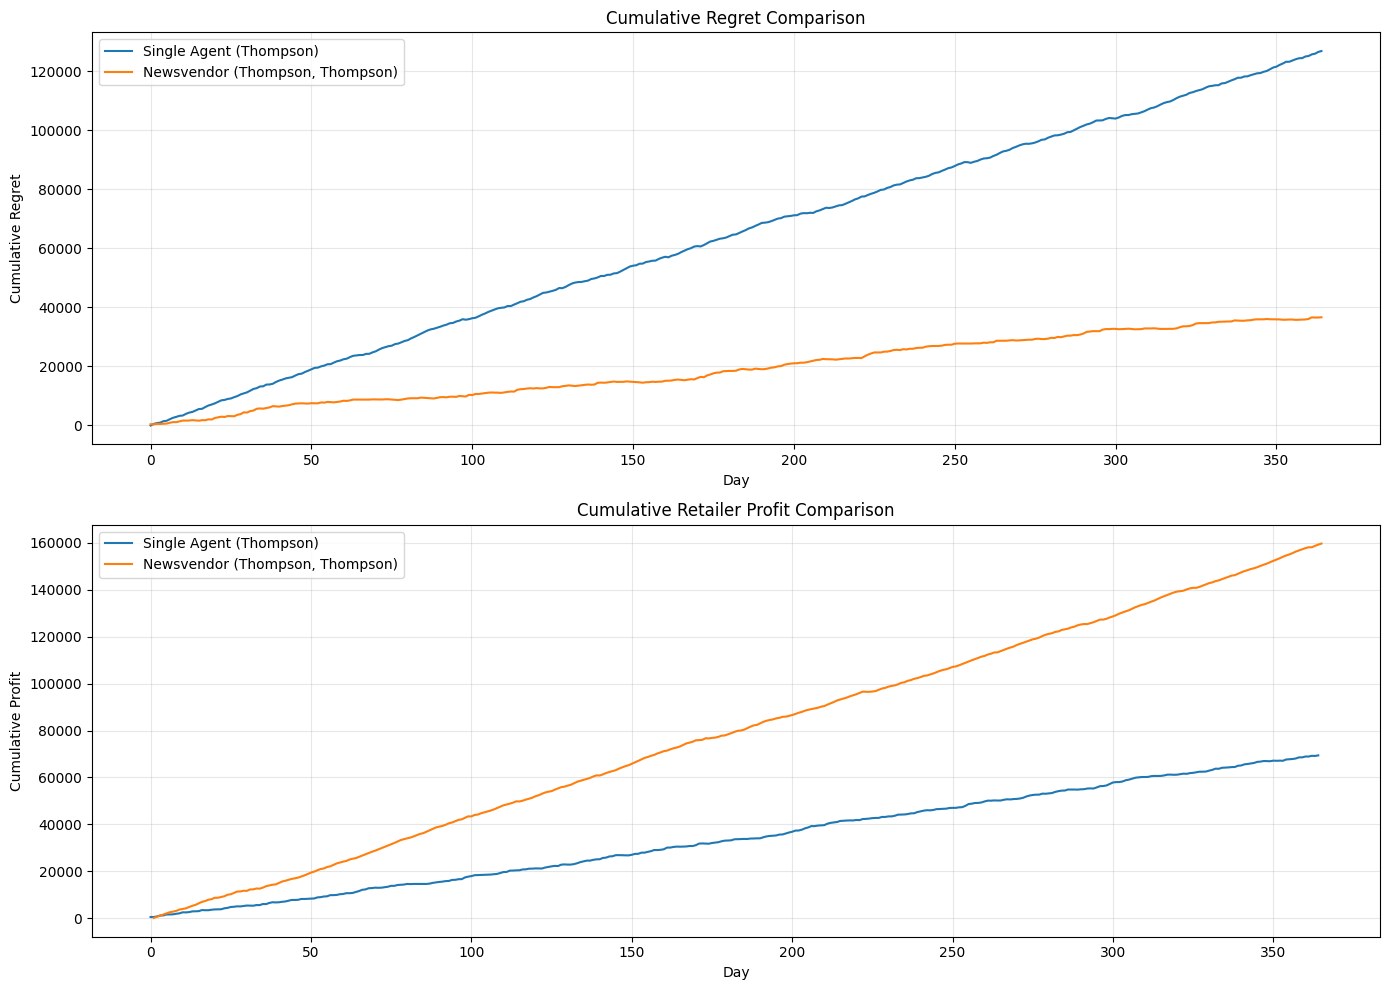

In [17]:
# Compare single-agent (greedy) vs newsvendor (greedy, greedy)
params.USE_PARTNER_PREDICTION = False
params.SUPPLIER_TEAM_PLAYER = True

single_greedy = SingleAgentPQModel(agent_type="thompson")
news_greedy = NewsVendorModel(agent_type=["thompson", "thompson", "thompson"])

for _ in range(params.ROUNDS):
    single_greedy.step()
    news_greedy.step()

single_df = single_greedy.datacollector.get_model_vars_dataframe()
news_df = news_greedy.datacollector.get_model_vars_dataframe()

news_agent_df = news_greedy.datacollector.get_agent_vars_dataframe().reset_index()
news_price_df = news_agent_df[news_agent_df["AgentID"] == 1][["Step", "Reward"]]

# Average profit comparison
single_avg_profit = float(single_df["profit"].mean())
news_avg_profit = float(news_price_df["Reward"].mean())
print(f"Single-agent avg profit: {single_avg_profit:.2f}")
print(f"Newsvendor avg profit: {news_avg_profit:.2f}")

# Plot comparison: cumulative regret and cumulative profit
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(single_df.index, single_df["Regret"].cumsum(), label="Single Agent (Thompson)")
axes[0].plot(news_df.index, news_df["Regret"].cumsum(), label="Newsvendor (Thompson, Thompson)")
axes[0].set_title("Cumulative Regret Comparison")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Cumulative Regret")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(single_df.index, single_df["profit"].cumsum(), label="Single Agent (Thompson)")
axes[1].plot(news_price_df["Step"], news_price_df["Reward"].cumsum(), label="Newsvendor (Thompson, Thompson)")
axes[1].set_title("Cumulative Retailer Profit Comparison")
axes[1].set_xlabel("Day")
axes[1].set_ylabel("Cumulative Profit")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Diagnostics: action space sizes and avg profit by agent type
params.USE_PARTNER_PREDICTION = False
params.SUPPLIER_TEAM_PLAYER = True

single_action_size = len(agents.joint_pq_action_space())
price_action_size = len(params.action_space_p())
quantity_action_size = len(params.action_space_q())
newsvendor_action_size = price_action_size + quantity_action_size

rows = []
for agent_type in ["greedy", "ucb", "thompson"]:
    single = SingleAgentPQModel(agent_type=agent_type)
    news = NewsVendorModel(agent_type=[agent_type, agent_type, agent_type])
    for _ in range(params.ROUNDS):
        single.step()
        news.step()
    single_df = single.datacollector.get_model_vars_dataframe()
    news_agent_df = news.datacollector.get_agent_vars_dataframe().reset_index()
    news_price_df = news_agent_df[news_agent_df["AgentID"] == 1][["Reward"]]
    rows.append({
        "agent_type": agent_type,
        "single_action_size": single_action_size,
        "newsvendor_action_size": newsvendor_action_size,
        "newsvendor_price_actions": price_action_size,
        "newsvendor_quantity_actions": quantity_action_size,
        "single_avg_profit": float(single_df["profit"].mean()),
        "news_avg_profit": float(news_price_df["Reward"].mean()),
    })

pd.DataFrame(rows)

In [ ]:
# Cumulative regret and profit by algorithm type
params.USE_PARTNER_PREDICTION = False
params.SUPPLIER_TEAM_PLAYER = True

rounds = 365*3
seed = params.SEED
params.SEED = seed

algorithms = ["greedy", "ucb", "thompson"]
fig, axes = plt.subplots(len(algorithms), 2, figsize=(14, 4 * len(algorithms)))
if len(algorithms) == 1:
    axes = np.array([axes])

for i, alg in enumerate(algorithms):
    single = SingleAgentPQModel(agent_type=alg, seed=seed)
    news = NewsVendorModel(agent_type=[alg, alg, alg])
    for _ in range(rounds):
        single.step()
        news.step()

    single_df = single.datacollector.get_model_vars_dataframe()
    news_df = news.datacollector.get_model_vars_dataframe()
    news_agent_df = news.datacollector.get_agent_vars_dataframe().reset_index()
    news_price_df = news_agent_df[news_agent_df["AgentID"] == 1][["Reward"]]
    rows.append({
        "algorithm": alg,
        "single_avg_profit": float(single_df["profit"].mean()),
        "single_avg_regret": float(single_df["Regret"].mean()),
        "news_avg_profit": float(news_price_df["Reward"].mean()),
        "news_avg_regret": float(news_df["Regret"].mean()),
    })

    # Cumulative regret
    axes[i, 0].plot(single_df.index, single_df["Regret"].cumsum(), label="Single")
    axes[i, 0].plot(news_df.index, news_df["Regret"].cumsum(), label="Multi-Agent")
    axes[i, 0].set_title(f"{alg.title()} - Cumulative Regret")
    axes[i, 0].set_xlabel("Day")
    axes[i, 0].set_ylabel("Cumulative Regret")
    axes[i, 0].grid(True, alpha=0.3)
    axes[i, 0].legend()

    # Cumulative profit
    axes[i, 1].plot(single_df.index, single_df["profit"].cumsum(), label="Single")
    axes[i, 1].plot(news_price_df.index, news_price_df["Reward"].cumsum(), label="Multi-Agent")
    axes[i, 1].set_title(f"{alg.title()} - Cumulative Profit")
    axes[i, 1].set_xlabel("Day")
    axes[i, 1].set_ylabel("Cumulative Profit")
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].legend()

plt.tight_layout()
plt.show()
pd.DataFrame(rows)

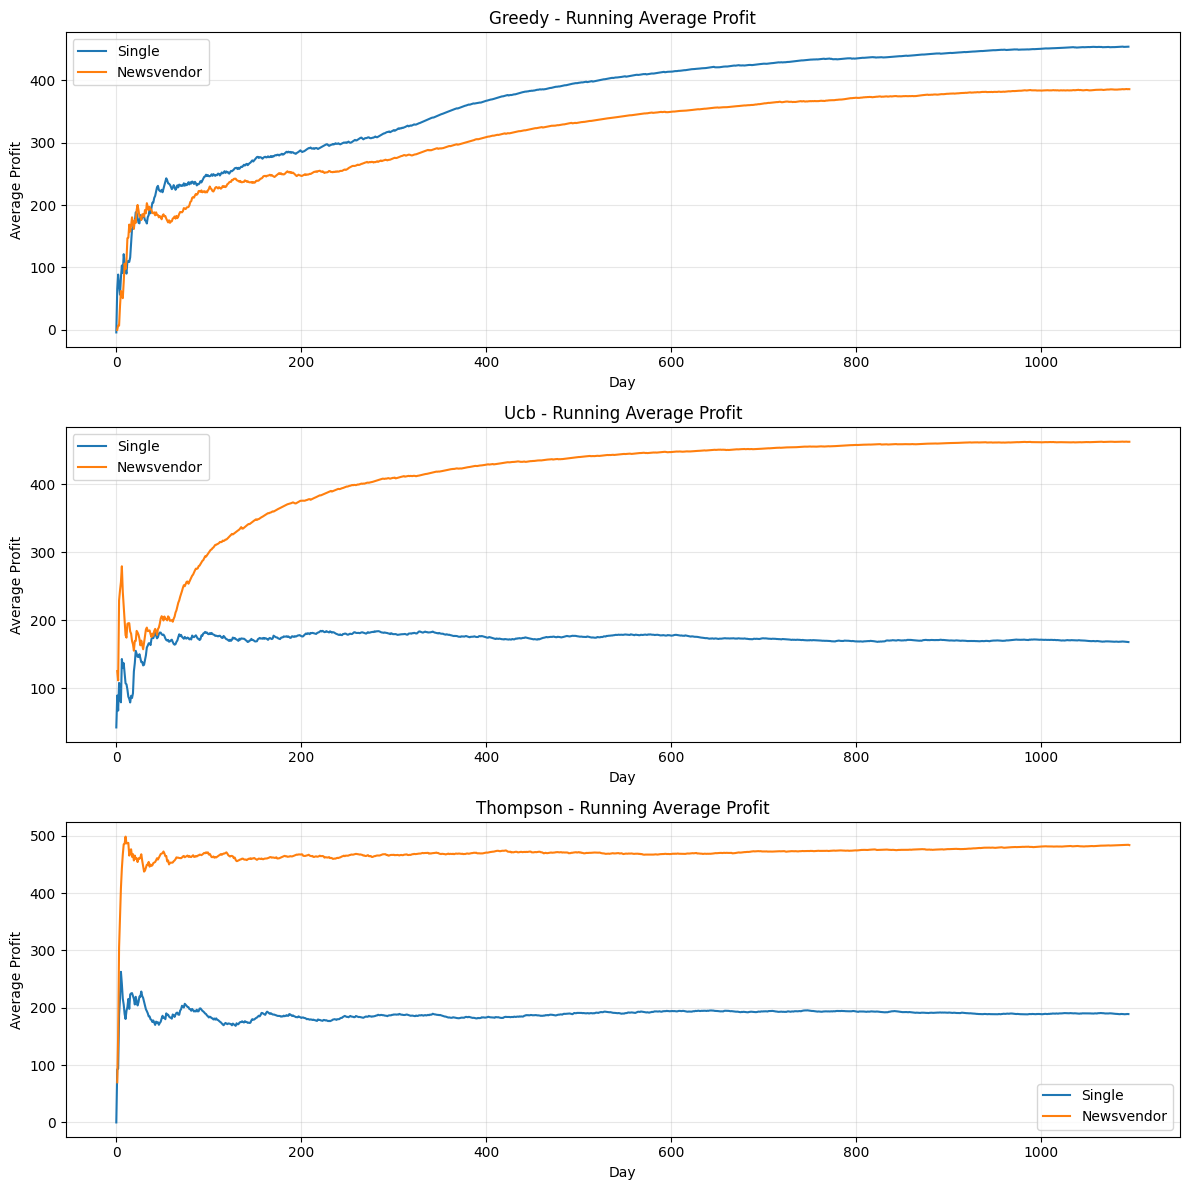

In [13]:
# Running average profit per algorithm (separate line graphs)
params.USE_PARTNER_PREDICTION = False
params.SUPPLIER_TEAM_PLAYER = True

rounds = params.ROUNDS*3
seed = params.SEED*13
params.SEED = seed

def running_mean(values):
    values = np.asarray(values, dtype=float)
    return np.cumsum(values) / np.arange(1, len(values) + 1)

algorithms = ["greedy", "ucb", "thompson"]
fig, axes = plt.subplots(len(algorithms), 1, figsize=(12, 4 * len(algorithms)))
if len(algorithms) == 1:
    axes = [axes]

for i, alg in enumerate(algorithms):
    single = SingleAgentPQModel(agent_type=alg, seed=seed)
    news = NewsVendorModel(agent_type=[alg, alg, alg])
    for _ in range(rounds):
        single.step()
        news.step()

    single_df = single.datacollector.get_model_vars_dataframe()
    news_agent_df = news.datacollector.get_agent_vars_dataframe().reset_index()
    news_price_df = news_agent_df[news_agent_df["AgentID"] == 1][["Step", "Reward"]] if "Step" in news_agent_df.columns else news_agent_df[news_agent_df["AgentID"] == 1][["Reward"]]
    if "Step" not in news_price_df.columns:
        news_price_df = news_price_df.copy()
        news_price_df["Step"] = np.arange(len(news_price_df))

    single_avg = running_mean(single_df["profit"])
    news_avg = running_mean(news_price_df["Reward"])

    axes[i].plot(single_df.index, single_avg, label="Single")
    axes[i].plot(news_price_df["Step"], news_avg, label="Newsvendor")
    axes[i].set_title(f"{alg.title()} - Running Average Profit")
    axes[i].set_xlabel("Day")
    axes[i].set_ylabel("Average Profit")
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [18]:
# Total average profit and total regret table (single vs newsvendor)
params.USE_PARTNER_PREDICTION = False
params.SUPPLIER_TEAM_PLAYER = True

rounds = params.ROUNDS
seed = params.SEED
params.SEED = seed

rows = []
for alg in ["greedy", "ucb", "thompson"]:
    single = SingleAgentPQModel(agent_type=alg, seed=seed)
    news = NewsVendorModel(agent_type=[alg, alg, alg])
    for _ in range(rounds):
        single.step()
        news.step()

    single_df = single.datacollector.get_model_vars_dataframe()
    news_df = news.datacollector.get_model_vars_dataframe()
    news_agent_df = news.datacollector.get_agent_vars_dataframe().reset_index()
    news_price_df = news_agent_df[news_agent_df["AgentID"] == 1][["Reward"]]
    rows.append({
        "algorithm": alg,
        "single_total_avg_profit": float(single_df["profit"].mean()),
        "newsvendor_total_avg_profit": float(news_price_df["Reward"].mean()),
        "single_total_regret": float(single_df["Regret"].sum()),
        "newsvendor_total_regret": float(news_df["Regret"].sum()),
    })

pd.DataFrame(rows)

,algorithm,single_total_avg_profit,newsvendor_total_avg_profit,single_total_regret,newsvendor_total_regret
0,greedy,354.552516,328.478782,66892.400832,76409.313384
1,ucb,173.141662,410.499609,133107.362321,46471.711830
2,thompson,176.849769,401.695917,131753.903194,49685.059148


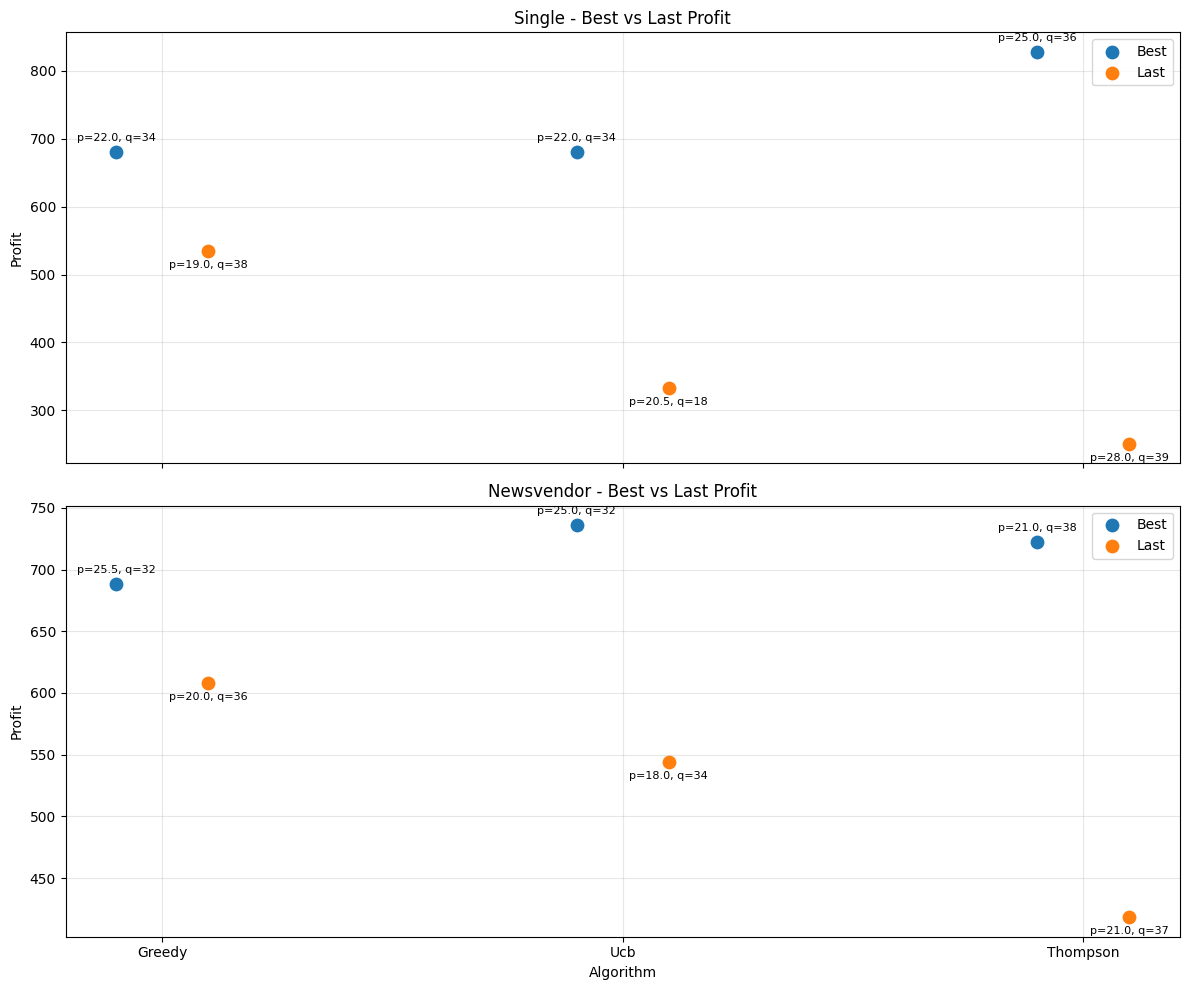

In [19]:
# Best vs last profit with corresponding (p, q) per algorithm
params.USE_PARTNER_PREDICTION = False
params.SUPPLIER_TEAM_PLAYER = True

rounds = params.ROUNDS
seed = params.SEED
params.SEED = seed

algorithms = ["greedy", "ucb", "thompson"]
rows = []
for alg in algorithms:
    single = SingleAgentPQModel(agent_type=alg, seed=seed)
    news = NewsVendorModel(agent_type=[alg, alg, alg])
    for _ in range(rounds):
        single.step()
        news.step()

    # Single-agent data
    single_df = single.datacollector.get_model_vars_dataframe().copy()
    single_best_idx = single_df["profit"].idxmax()
    single_last_idx = single_df.index[-1]
    rows.append({
        "algorithm": alg,
        "scenario": "single",
        "best_profit": float(single_df.loc[single_best_idx, "profit"]),
        "best_p": float(single_df.loc[single_best_idx, "p"]),
        "best_q": int(single_df.loc[single_best_idx, "q"]),
        "last_profit": float(single_df.loc[single_last_idx, "profit"]),
        "last_p": float(single_df.loc[single_last_idx, "p"]),
        "last_q": int(single_df.loc[single_last_idx, "q"]),
    })

    # Newsvendor data (price agent reward + price/qty actions)
    news_agent_df = news.datacollector.get_agent_vars_dataframe().reset_index()
    price_df = news_agent_df[news_agent_df["AgentID"] == 1][["Step", "Action", "Reward"]].rename(columns={"Action": "Price"})
    qty_df = news_agent_df[news_agent_df["AgentID"] == 2][["Step", "Action"]].rename(columns={"Action": "Quantity"})
    news_pq = price_df.merge(qty_df, on="Step")
    news_best_idx = news_pq["Reward"].idxmax()
    news_last_idx = news_pq.index[-1]
    rows.append({
        "algorithm": alg,
        "scenario": "newsvendor",
        "best_profit": float(news_pq.loc[news_best_idx, "Reward"]),
        "best_p": float(news_pq.loc[news_best_idx, "Price"]),
        "best_q": int(news_pq.loc[news_best_idx, "Quantity"]),
        "last_profit": float(news_pq.loc[news_last_idx, "Reward"]),
        "last_p": float(news_pq.loc[news_last_idx, "Price"]),
        "last_q": int(news_pq.loc[news_last_idx, "Quantity"]),
    })

summary = pd.DataFrame(rows)
summary

# Plot: best vs last profit with (p,q) annotations
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
for ax_idx, scenario in enumerate(["single", "newsvendor"]):
    subset = summary[summary["scenario"] == scenario].reset_index(drop=True)
    x = np.arange(len(subset["algorithm"]))
    ax = axes[ax_idx]
    ax.scatter(x - 0.1, subset["best_profit"], label="Best", s=80)
    ax.scatter(x + 0.1, subset["last_profit"], label="Last", s=80)
    for i, row in subset.iterrows():
        ax.annotate(f"p={row['best_p']:.1f}, q={row['best_q']}", (x[i]-0.1, row["best_profit"]), textcoords="offset points", xytext=(0, 8), ha="center", fontsize=8)
        ax.annotate(f"p={row['last_p']:.1f}, q={row['last_q']}", (x[i]+0.1, row["last_profit"]), textcoords="offset points", xytext=(0, -12), ha="center", fontsize=8)
    ax.set_title(f"{scenario.title()} - Best vs Last Profit")
    ax.set_ylabel("Profit")
    ax.grid(True, alpha=0.3)
    ax.legend()
axes[-1].set_xticks(x)
axes[-1].set_xticklabels(subset["algorithm"].str.title())
axes[-1].set_xlabel("Algorithm")
plt.tight_layout()
plt.show()

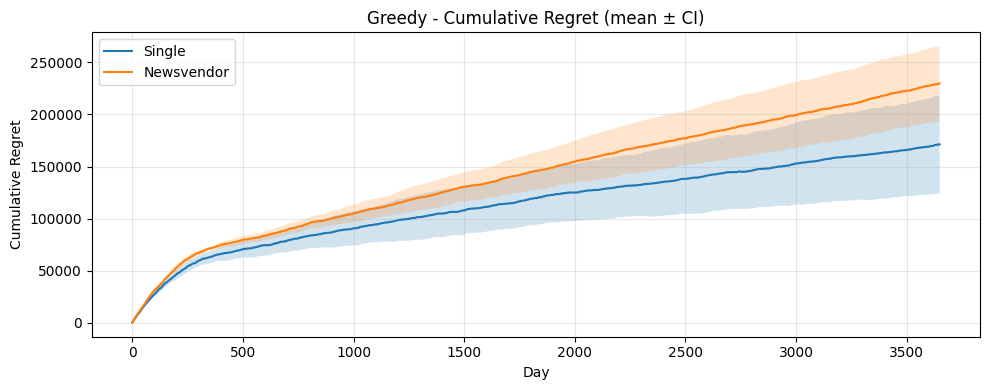

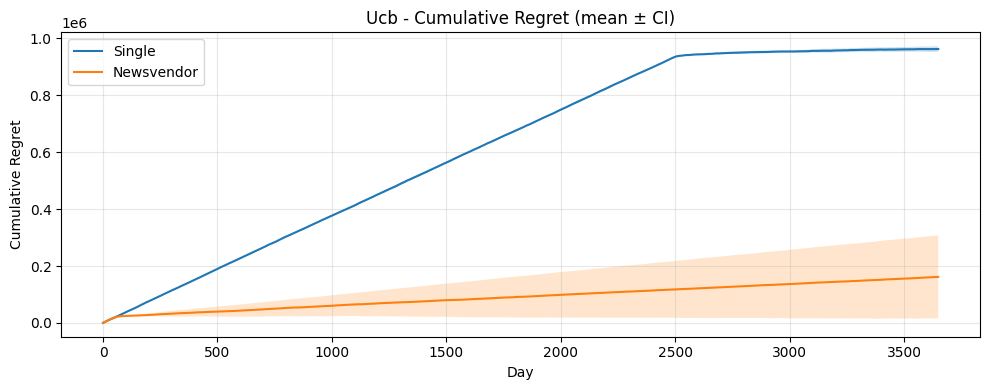

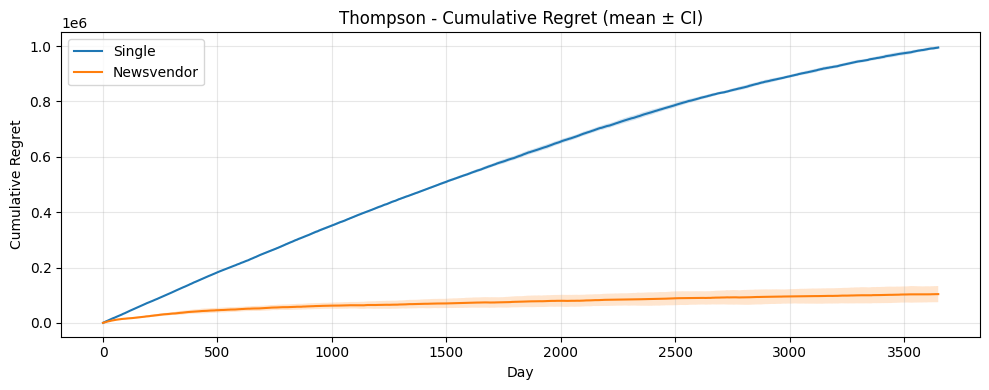

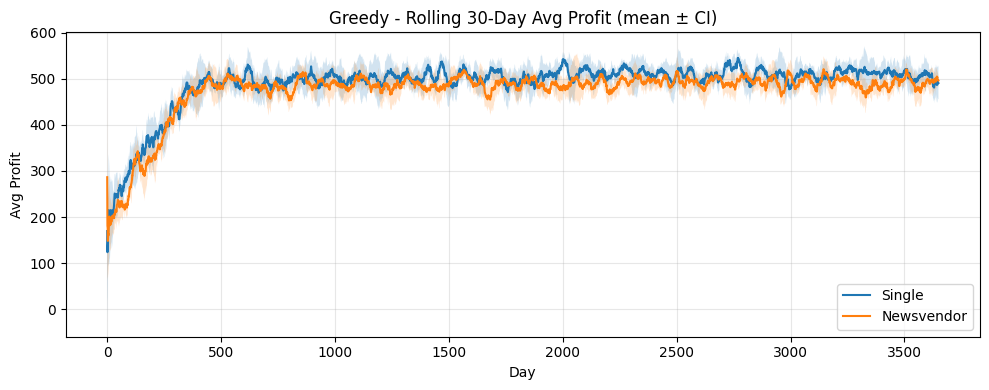

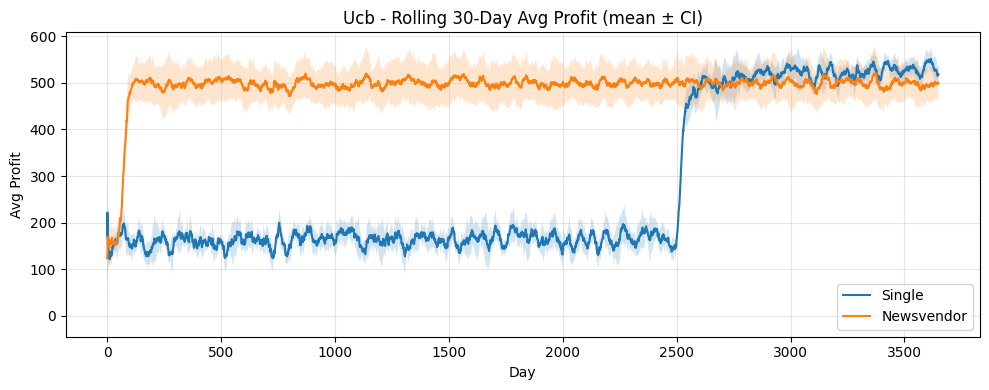

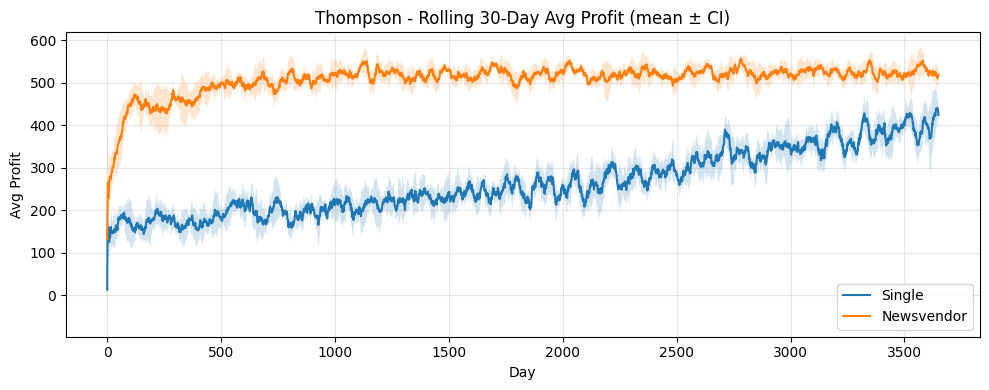

,algorithm,metric,single_mean,single_ci_low,single_ci_high,newsvendor_mean,newsvendor_ci_low,newsvendor_ci_high
0,greedy,avg_profit_last_100_days,503.508511,485.433546,521.583477,492.381424,476.754308,508.008541
1,greedy,time_to_95_oracle_profit_days,2920.000000,1489.200000,4350.800000,2920.000000,1489.200000,4350.800000
2,ucb,avg_profit_last_100_days,530.540679,515.084549,545.996809,495.913445,461.008559,530.818331
3,ucb,time_to_95_oracle_profit_days,3650.000000,3650.000000,3650.000000,2360.400000,1275.842080,3444.957920
4,thompson,avg_profit_last_100_days,402.892564,363.784348,442.000780,529.490910,523.966603,535.015216
5,thompson,time_to_95_oracle_profit_days,3650.000000,3650.000000,3650.000000,2284.400000,1036.923729,3531.876271


In [ ]:
# Metrics with CI over seeds per algorithm (single vs newsvendor)
params.USE_PARTNER_PREDICTION = False
params.SUPPLIER_TEAM_PLAYER = True

rounds = params.ROUNDS*10
seeds = [0, 1, 2, 3, 4]
algorithms = ["greedy", "ucb", "thompson"]
z = 1.96  # approx 95% CI
window = 30
last_n = 100

oracle_profit = float(params.PROFIT_OPTIMA_MAP.get(params.MANUFACTURING_COST, 0.0))
target_profit = 0.95 * oracle_profit

def ci_mean(arrs):
    arr = np.array(arrs, dtype=float)
    mean = arr.mean(axis=0)
    if arr.shape[0] > 1:
        se = arr.std(axis=0, ddof=1) / np.sqrt(arr.shape[0])
    else:
        se = np.zeros_like(mean)
    return mean, mean - z * se, mean + z * se

def run_once(alg, seed):
    params.SEED = seed
    single = SingleAgentPQModel(agent_type=alg, seed=seed)
    news = NewsVendorModel(agent_type=[alg, alg, alg], seed=seed)
    for _ in range(rounds):
        single.step()
        news.step()
    single_df = single.datacollector.get_model_vars_dataframe()
    news_df = news.datacollector.get_model_vars_dataframe()
    news_agent_df = news.datacollector.get_agent_vars_dataframe().reset_index()
    news_price_df = news_agent_df[news_agent_df["AgentID"] == 1][["Step", "Reward"]]
    if "Step" in news_price_df.columns:
        news_price_df = news_price_df.sort_values("Step")
        news_profit = news_price_df["Reward"].to_numpy()
    else:
        news_profit = news_price_df["Reward"].to_numpy()
    single_profit = single_df["profit"].to_numpy()
    single_regret = single_df["Regret"].to_numpy()
    news_regret = news_df["Regret"].to_numpy()
    return single_profit, single_regret, news_profit, news_regret

def rolling_mean(x, w):
    x = pd.Series(x)
    return x.rolling(window=w, min_periods=1).mean().to_numpy()

results = {}
for alg in algorithms:
    single_profits = []
    news_profits = []
    single_regrets = []
    news_regrets = []
    single_time95 = []
    news_time95 = []
    single_last100 = []
    news_last100 = []

    for s in seeds:
        sp, sr, npf, nr = run_once(alg, s)
        single_profits.append(sp)
        news_profits.append(npf)
        single_regrets.append(np.cumsum(sr))
        news_regrets.append(np.cumsum(nr))

        single_avg = np.cumsum(sp) / np.arange(1, len(sp) + 1)
        news_avg = np.cumsum(npf) / np.arange(1, len(npf) + 1)
        single_time95.append(int(np.argmax(single_avg >= target_profit)) if np.any(single_avg >= target_profit) else len(single_avg))
        news_time95.append(int(np.argmax(news_avg >= target_profit)) if np.any(news_avg >= target_profit) else len(news_avg))

        single_last100.append(float(np.mean(sp[-last_n:])) if len(sp) >= last_n else float(np.mean(sp)))
        news_last100.append(float(np.mean(npf[-last_n:])) if len(npf) >= last_n else float(np.mean(npf)))

    results[alg] = {
        "single_profits": single_profits,
        "news_profits": news_profits,
        "single_regrets": single_regrets,
        "news_regrets": news_regrets,
        "single_time95": single_time95,
        "news_time95": news_time95,
        "single_last100": single_last100,
        "news_last100": news_last100,
    }

# Plot 1: Cumulative regret (mean ± CI) — separate plot per algorithm
for alg in algorithms:
    m, lo, hi = ci_mean(results[alg]["single_regrets"])
    m2, lo2, hi2 = ci_mean(results[alg]["news_regrets"])
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(m, label="Single")
    ax.fill_between(np.arange(len(m)), lo, hi, alpha=0.2)
    ax.plot(m2, label="Newsvendor")
    ax.fill_between(np.arange(len(m2)), lo2, hi2, alpha=0.2)
    ax.set_title(f"{alg.title()} - Cumulative Regret (mean ± CI)")
    ax.set_xlabel("Day")
    ax.set_ylabel("Cumulative Regret")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Plot 2: Rolling 30-day average profit (mean ± CI) — separate plot per algorithm
for alg in algorithms:
    single_roll = [rolling_mean(p, window) for p in results[alg]["single_profits"]]
    news_roll = [rolling_mean(p, window) for p in results[alg]["news_profits"]]
    m, lo, hi = ci_mean(single_roll)
    m2, lo2, hi2 = ci_mean(news_roll)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(m, label="Single")
    ax.fill_between(np.arange(len(m)), lo, hi, alpha=0.2)
    ax.plot(m2, label="Newsvendor")
    ax.fill_between(np.arange(len(m2)), lo2, hi2, alpha=0.2)
    ax.set_title(f"{alg.title()} - Rolling {window}-Day Avg Profit (mean ± CI)")
    ax.set_xlabel("Day")
    ax.set_ylabel("Avg Profit")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Tables for Plot 3 and Plot 4 metrics (no plots)
table_rows = []
for alg in algorithms:
    single_last = np.mean(results[alg]["single_last100"])
    news_last = np.mean(results[alg]["news_last100"])
    single_err = (np.std(results[alg]["single_last100"], ddof=1) / np.sqrt(len(seeds)) if len(seeds) > 1 else 0) * z
    news_err = (np.std(results[alg]["news_last100"], ddof=1) / np.sqrt(len(seeds)) if len(seeds) > 1 else 0) * z
    table_rows.append({
        "algorithm": alg,
        "metric": f"avg_profit_last_{last_n}_days",
        "single_mean": float(single_last),
        "single_ci_low": float(single_last - single_err),
        "single_ci_high": float(single_last + single_err),
        "newsvendor_mean": float(news_last),
        "newsvendor_ci_low": float(news_last - news_err),
        "newsvendor_ci_high": float(news_last + news_err),
    })

    single_t = np.mean(results[alg]["single_time95"])
    news_t = np.mean(results[alg]["news_time95"])
    single_t_err = (np.std(results[alg]["single_time95"], ddof=1) / np.sqrt(len(seeds)) if len(seeds) > 1 else 0) * z
    news_t_err = (np.std(results[alg]["news_time95"], ddof=1) / np.sqrt(len(seeds)) if len(seeds) > 1 else 0) * z
    table_rows.append({
        "algorithm": alg,
        "metric": "time_to_95_oracle_profit_days",
        "single_mean": float(single_t),
        "single_ci_low": float(single_t - single_t_err),
        "single_ci_high": float(single_t + single_t_err),
        "newsvendor_mean": float(news_t),
        "newsvendor_ci_low": float(news_t - news_t_err),
        "newsvendor_ci_high": float(news_t + news_t_err),
    })

table_df = pd.DataFrame(table_rows)
oracle_df = pd.DataFrame([{
    "metric": "oracle_profit",
    "value": oracle_profit,
}, {
    "metric": "target_profit_95pct",
    "value": target_profit,
}])

table_df, oracle_df